In this simple notebook, we will use CatBoost to predict the price using only categorical features.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import catboost as cboost

%matplotlib inline

In [4]:
df_train = pd.read_csv('train.tsv', sep='\t', index_col='train_id')
df_test = pd.read_csv('test.tsv', sep='\t', index_col='test_id')

In [5]:
# Sneak peek on data
df_train.sample(10, random_state=42)

name  item_condition_id  \
train_id                                                            
777341           F/ship 4 Totoro Washi + 1 pen                  1   
1463629             UCLA Men's Bundle + Shorts                  1   
350669                         Listing for lol                  1   
310222            25 pcs kawaii sticker flakes                  1   
759257                Chanel Mini Lipgloss Set                  2   
288846                      Maroon Foamposites                  3   
1178450   INC studdedHeart Black Blouse Dolman                  2   
726296                    Leggo silicone molds                  3   
840510                       Supreme Uzi Chain                  1   
1473033    Women Gold Palm Pendant Necklace FC                  1   

                                    category_name                  brand_name  \
train_id                                                                        
777341            Handmade/Paper Goods/Stationery                         NaN   
1463629                         Women/Other/Other                      Adidas   
350669                         Beauty/Makeup/Lips                         NaN   
310222                    Kids/Toys/Arts & Crafts                         NaN   
759257                         Beauty/Makeup/Lips                      Chanel   
288846                 Men/Shoes/Fashion Sneakers                        Nike   
1178450               Women/Tops & Blouses/Blouse  INC International Concepts   
726296             Home/Kitchen & Dining/Bakeware                         NaN   
840510                   Handmade/Accessories/Men                         NaN   
1473033   Vintage & Collectibles/Jewelry/Necklace                         NaN   

          price  shipping                                   item_description  
train_id                                                                      
777341     12.0         1  This listing is for all 4 Totoro washi tape fo...  
1463629    76.0         1  7 items. 1: XL. 2: 2XL. 3:2XL. 4: XL. 5: 2XL. ...  
350669     12.0         1                       - sunglasses and necklace :)  
310222      3.0         1  I ordered a bunch of stickers so you will reci...  
759257     30.0         1  Brand new never used authentic Mini Lipgloss g...  
288846    225.0         1                             9/10 Condition N Sz 12  
1178450    16.0         1  New without tags INC International Concepts Sh...  
726296     12.0         0  I used these for my son's leggo birthday party...  
840510     15.0         1                                          10/10 New  
1473033    17.0         1  High quality Immediate purchase Ok? Free shipp...

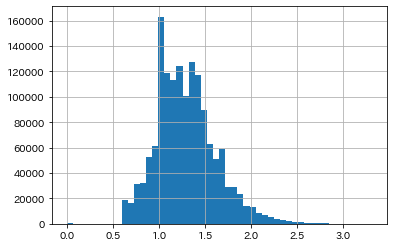

In [6]:
# Log price distribution
(df_train.price + 1).apply(np.log10).hist(bins=50);

In [7]:
# We only use categorical features in this naive approach
categorical_features = ['item_condition_id', 'category_name', 'brand_name', 'shipping']

df_x_train = df_train[categorical_features].copy()
df_x_test = df_test[categorical_features].copy()
df_y_log = np.log(df_train['price']+1)

In [8]:
# Factorize both train and test (avoid unseen categories in train)
# def factorize(train, test, col, min_count):
#     cat_ids = sorted(set(train[col].dropna().unique()) | set(test[col].dropna().unique()))

#     cat_ids = {k:i for i, k in enumerate(cat_ids)}
#     cat_ids[np.nan] = -1

#     train[col] = train[col].map(cat_ids)
#     test[col]  = test[col].map(cat_ids)
def factorize(train, test, col, min_count):
    train_cat_count = train[col].value_counts()
    test_cat_count = test[col].value_counts()
    
    train_cat = set(train_cat_count[(train_cat_count >= min_count)].index)

    cat_ids = {k:i for i, k in enumerate(sorted(train_cat))}
    cat_ids[np.nan] = -1
    
    train[col] = train[col].map(cat_ids)
    train[col] = train[col].fillna(len(cat_ids))  # Create 'other' category

    test[col] = test[col].map(cat_ids)
    test[col] = test[col].fillna(len(cat_ids))

# Factorize string columns
factorize(df_x_train, df_x_test, 'category_name', min_count=50)
factorize(df_x_train, df_x_test, 'brand_name', min_count=50)

In [9]:
df_x_train.nunique()

item_condition_id      5
category_name        705
brand_name           814
shipping               2
dtype: int64

In [11]:
# Create train and test Pool of train
ptrain = cboost.Pool(df_x_train, df_y_log, cat_features=np.arange(len(categorical_features)),
                     column_description=categorical_features)

ptest = cboost.Pool(df_x_test, cat_features=np.arange(len(categorical_features)),
                     column_description=categorical_features)

# Add subsample of train for cross-validation speed
# sub_idx = np.random.choice(len(df_x_train), int(len(df_x_train) * 0.5), replace=False)
# ptrain_sub = cboost.Pool(df_x_train.iloc[sub_idx], df_y_log.iloc[sub_idx],
#                      cat_features=np.arange(len(categorical_features)),
#                      column_description=categorical_features)

CatBoostError: data should be the string or pathlib.Path type if column_description parameter is specified.

In [ ]:
# Tune your parameters here!
cboost_params = {
    'nan_mode': 'Min',
    'loss_function': 'RMSE',  # Try 'LogLinQuantile' as well
    'iterations': 200,
    'learning_rate': 1.0,
    'depth': 11,
    'verbose': True
}

best_iter = cboost_params['iterations']  # Initial 'guess' it not using CV

# cv_result = cboost.cv(cboost_params, ptrain_sub, fold_count=3)

# df_cv_result = pd.DataFrame({'train': cv_result['RMSE_train_avg'],
#                              'valid': cv_result['RMSE_test_avg']})

# # Best results
# print('Best results:')
# best_iter = df_cv_result.valid.argmin()+1
# df_cv_bestresult = df_cv_result.iloc[best_iter-1]
# print(df_cv_bestresult)

# fig, ax = plt.subplots(1, 2, figsize=(15, 6))
# df_cv_result.plot(ax=ax[0])

# ax[1].plot(df_cv_result.train, df_cv_result.valid, 'o-')
# ax[1].scatter([df_cv_bestresult['train']], [df_cv_bestresult['valid']], c='red')
# ax[1].set_xlabel('train')
# ax[1].set_ylabel('valid')

In [ ]:
# Train model on full data
model = cboost.CatBoostRegressor(**dict(cboost_params, verbose=False, iterations=best_iter))

fit_model = model.fit(ptrain)

In [ ]:
# Predict test and save to .csv
df_test['price_log'] = fit_model.predict(ptest).clip(0)  # Avoid negative prices

df_test['price'] = np.exp(df_test['price_log'])-1

df_test[['price']].round(5).to_csv('submission.csv', index=True)

In [ ]:
!head submission.csv